In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)


pipline操作流程：

1.生成数据：a 单起始点时间序列；b 多起始点时间序列

可选步骤：时间序列降采样

2.选择合适的library做观测

3.选择合适的optimizer做拟合：a 离散的迭代方程；b 连续的微分方程

4.计算score，多步预测效果看一下

5.提取系数矩阵，进行svd分解，得到奇异值谱和左奇异向量

6.观察奇异值谱截断，计算因果涌现程度，绘制多尺度contribution，计算EC

7.根据奇异向量和谱截断，输出粗粒化函数表达式

8.绘制宏观演化的时间序列，给出宏观动力学方程

可选的分析案例：

1.SIR：原始的SIR动力学；带观测噪音的四维微观数据

2.kuramoto模型

3.洛伦兹动力学

4.耦合Rulkov映射

# 数据生成

In [56]:
N=12
n_clusters=3  # 团数
K_intra=5
K_inter=0.1
noise=0
dt=0.01

In [ ]:
# # 多时间序列采样
# T=5
# batch = 1000
# t_list = []
# x_data = []
# for seed in range(batch):
#     x_train, theta_hist, t_train, K_matrix = generate_kuramoto_cluster_data_sin_cos(
#         N=N, n_clusters=n_clusters, K_intra=K_intra, K_inter=K_inter, dt=dt, T=T, noise=noise, random_seed1=0, random_seed2=seed
#     )
#     x_data.append(x_train)
#     t_list.append(t_train)

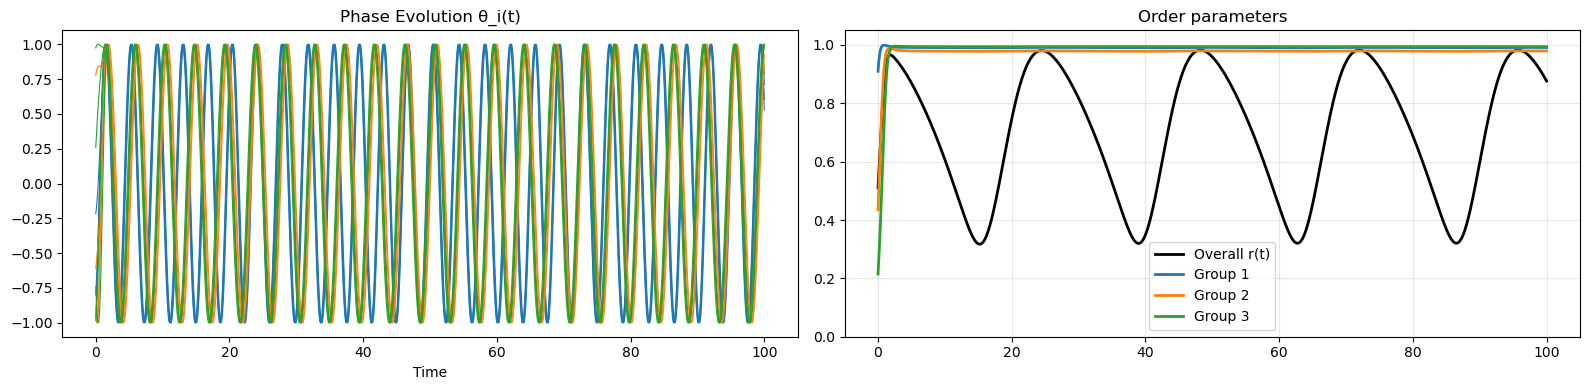

In [57]:
# 单时间序列采样
x_train, theta_hist, t_train, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=n_clusters,  # 团数
    K_intra=K_intra,   # 团内耦合
    K_inter=K_inter,   # 团间耦合
    noise=noise,
    T=100,
    random_seed1=0, random_seed2=0,
    dt=dt
)

x_data = x_train


# 选择library

In [58]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=1,include_bias=True)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide #+ fourier

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(10000, 24)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23']


# 进行拟合

In [59]:
# 离散的迭代方程 or 连续的微分方程
discrete_time=False

# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l1")
lasso_optimizer = Lasso(alpha=0.01, max_iter=20000, fit_intercept=False)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

(x0)' = 0.013 x8 + -1.562 x12 + -0.006 x13 + -0.032 x14 + -0.054 x15
(x1)' = 0.079 x3 + 0.012 x9 + -0.868 x13 + -0.746 x14
(x2)' = 0.007 x6 + -1.648 x14
(x3)' = 0.014 x8 + -0.018 x12 + -1.638 x15
(x4)' = 0.003 x3 + -1.397 x16
(x5)' = 0.001 x2 + 0.103 x11 + -0.922 x17 + -0.073 x18 + -0.326 x19
(x6)' = 0.003 x3 + -0.038 x16 + -0.021 x17 + -1.337 x18
(x7)' = 0.133 x9 + -0.899 x19 + -0.450 x20
(x8)' = 0.001 x1 + -0.136 x18 + -1.133 x20 + -0.112 x21
(x9)' = 0.009 x3 + -0.003 x18 + -1.395 x21
(x10)' = -0.347 x20 + -0.126 x21 + -0.890 x22 + -0.019 x23
(x11)' = -1.394 x23
(x12)' = 1.652 x0 + 0.010 x22
(x13)' = 1.646 x1 + 0.010 x18
(x14)' = 0.017 x0 + 0.033 x1 + 1.599 x2 + 0.007 x18
(x15)' = 0.008 x0 + 1.645 x3 + 0.010 x22
(x16)' = 1.399 x4 + 0.004 x13 + 0.003 x15
(x17)' = 1.244 x5 + 0.129 x7 + 0.017 x23
(x18)' = 1.394 x6 + 0.002 x9 + 0.006 x13
(x19)' = 0.587 x5 + 0.569 x7 + 0.246 x9
(x20)' = -0.002 x3 + 0.084 x5 + 0.816 x8 + 0.480 x9
(x21)' = 1.400 x9 + 0.009 x15
(x22)' = 0.018 x4 + 0.887 x8 +

In [60]:
# 计算score
model.score(x_data_lift, t=dt)

0.9972986995372873

# 多步预测

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_89491/615257827.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


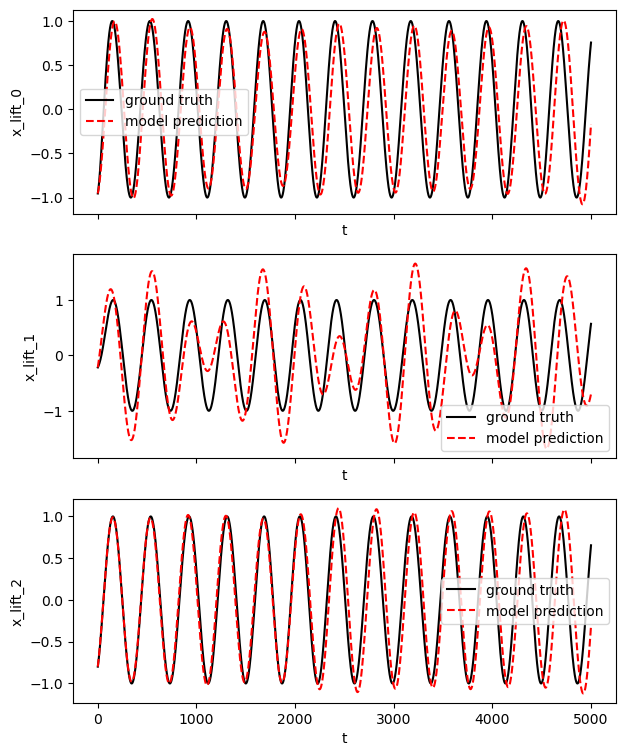

In [61]:
# 单时间序列
init_data = x_data_lift[0,:]
steps = 5000
# 多时间序列
#init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,len(t_train)-1)
else:
    X_data_predicted = model.simulate(init_data,t_train) 

# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[:steps, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:steps, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

# svd分解

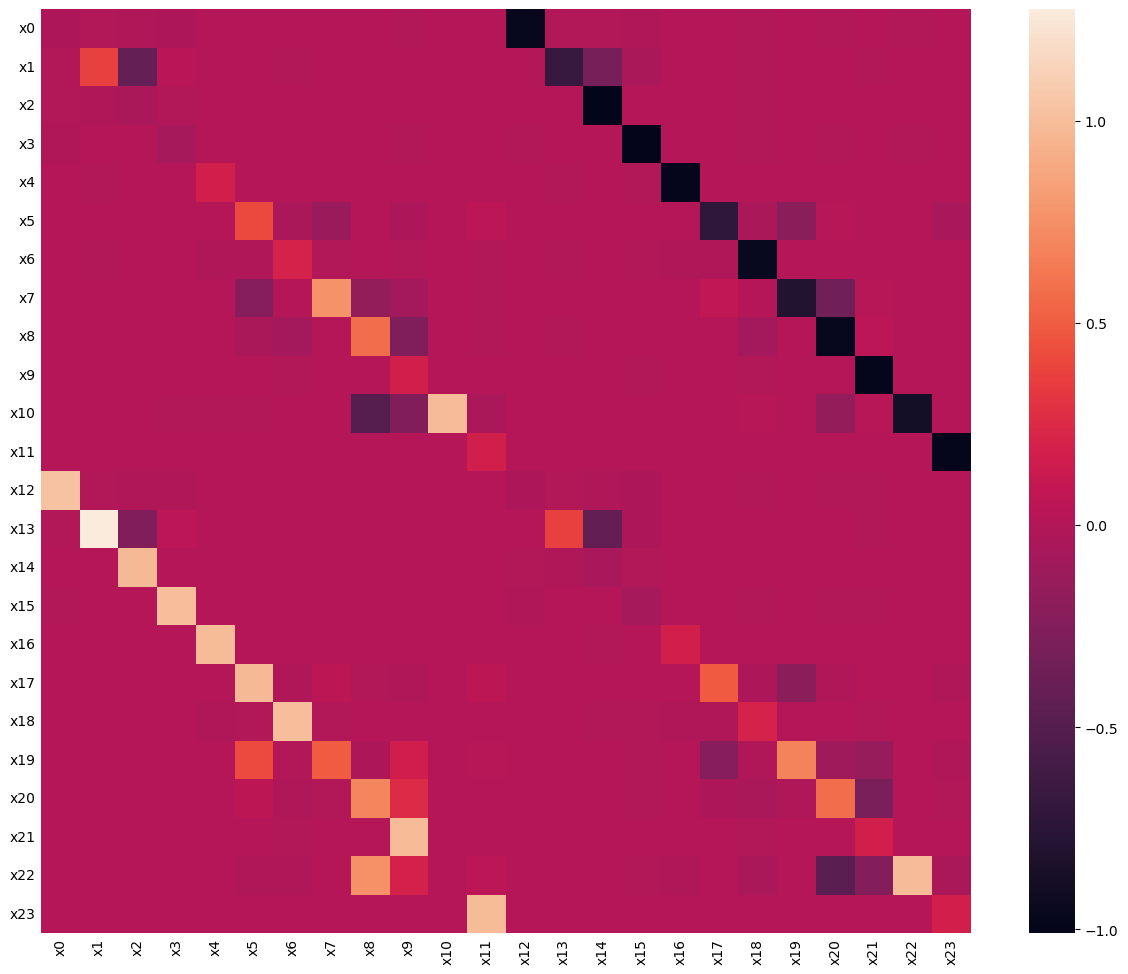

In [62]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

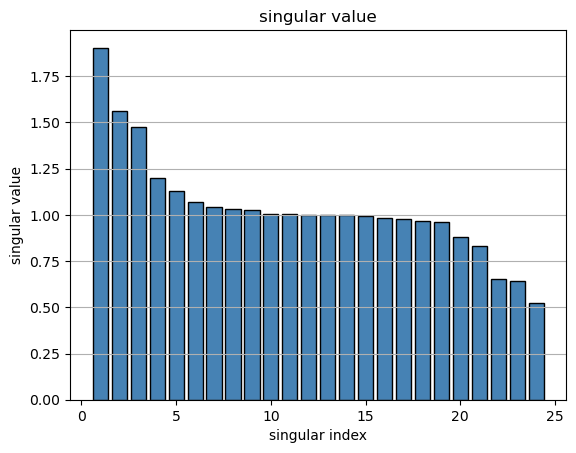

In [63]:
# SVD
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

In [64]:
# 选取截断
rank = 3
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

0.6113572818155795


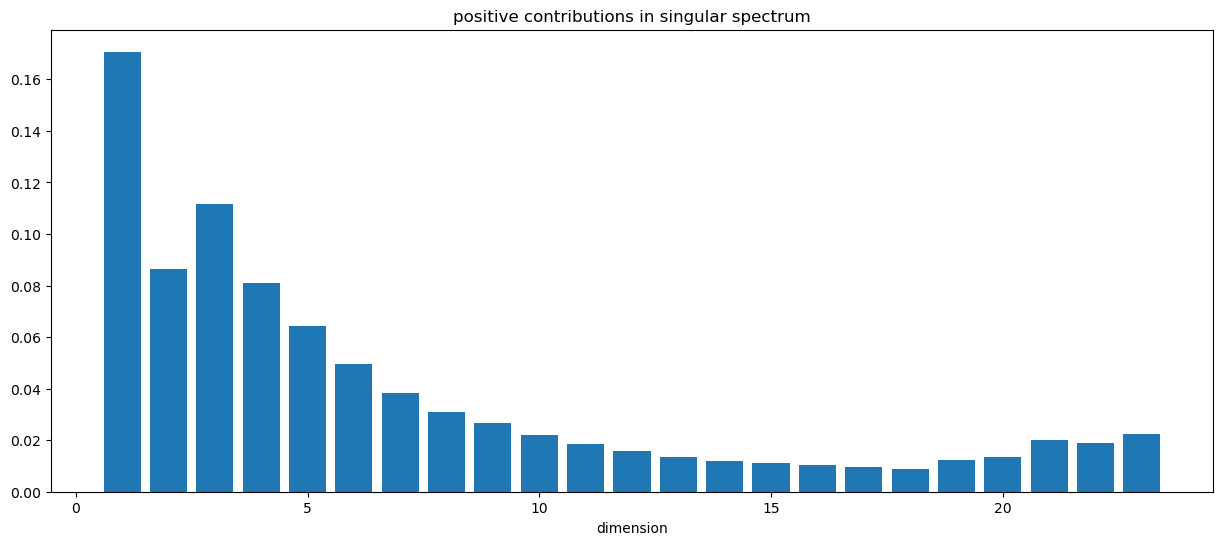

In [65]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [66]:
# 计算EC
print(compute_entropy(diff))

3.925311412574647


# 输出粗粒化表达式

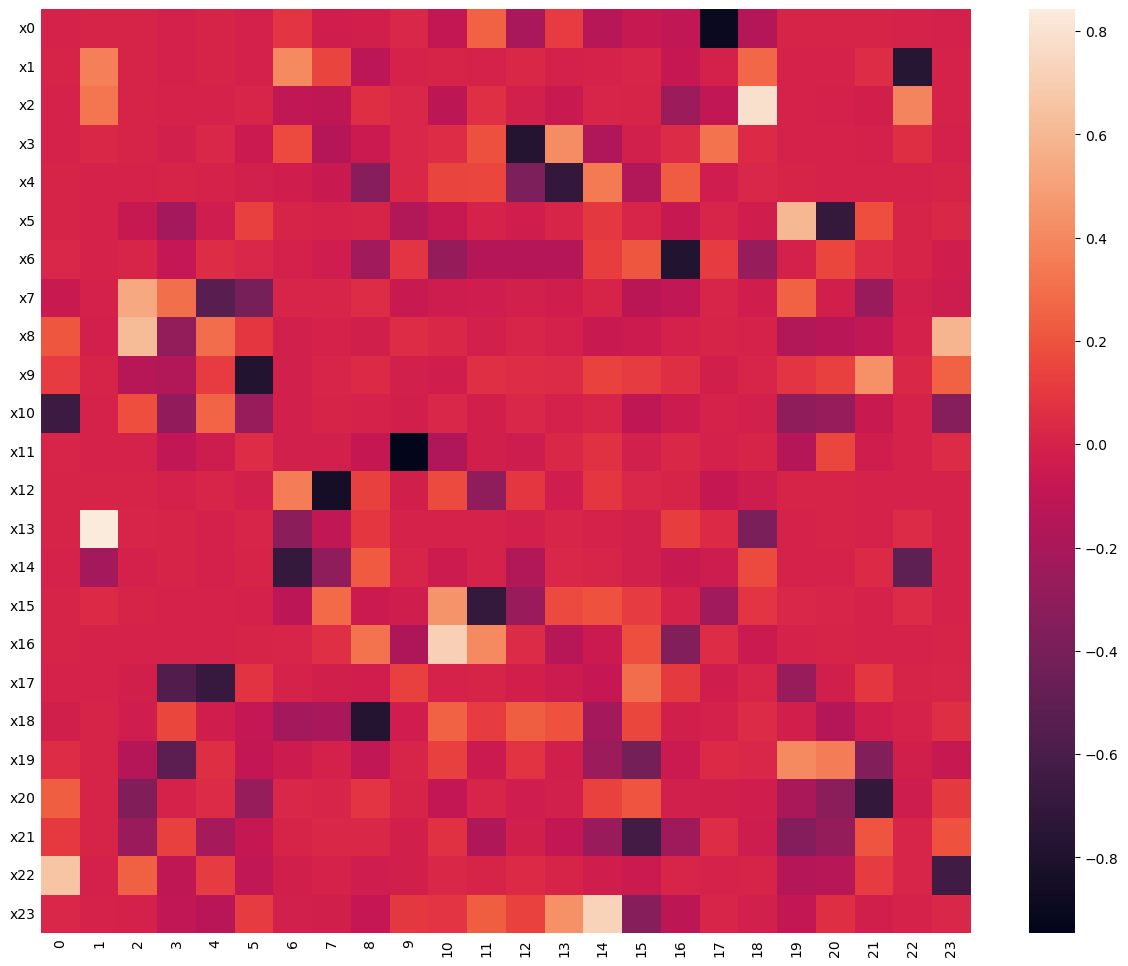

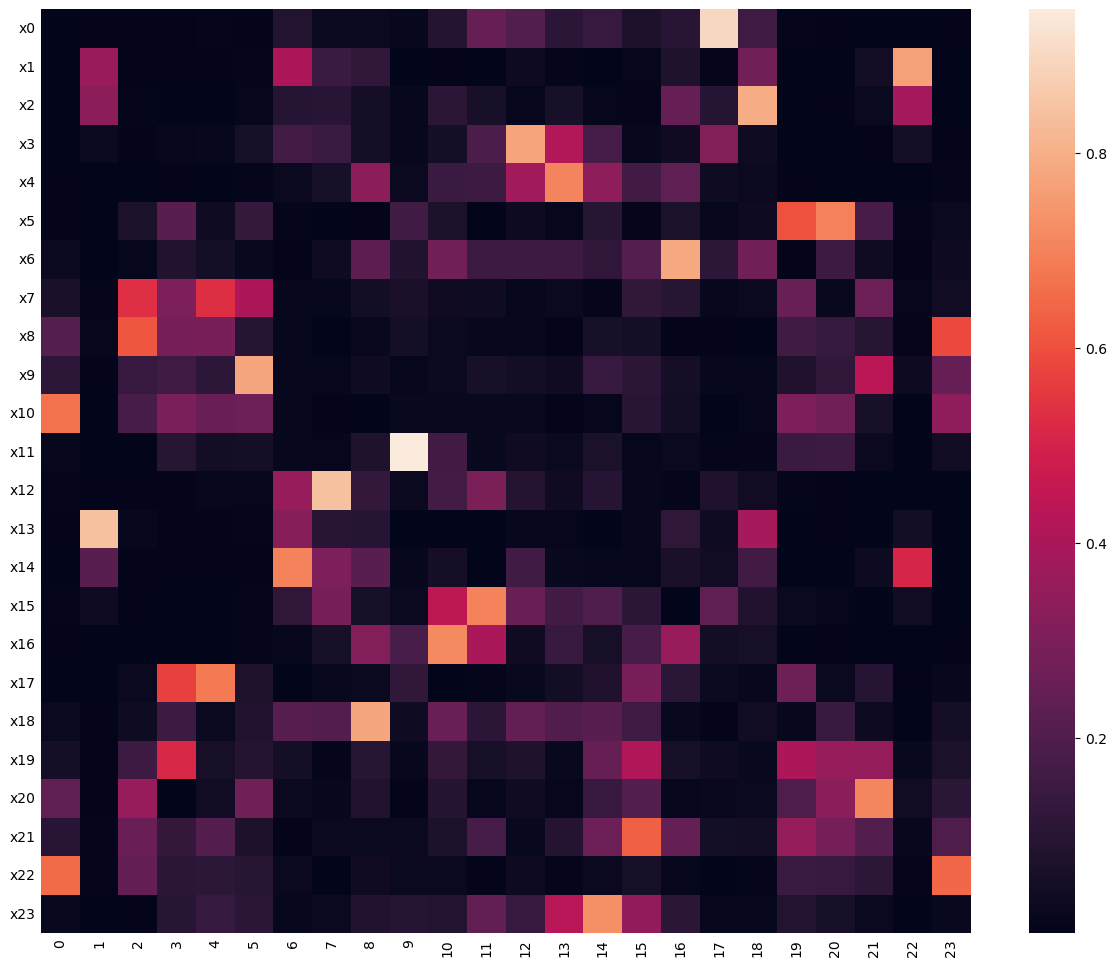

In [67]:
# 绘制奇异向量
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

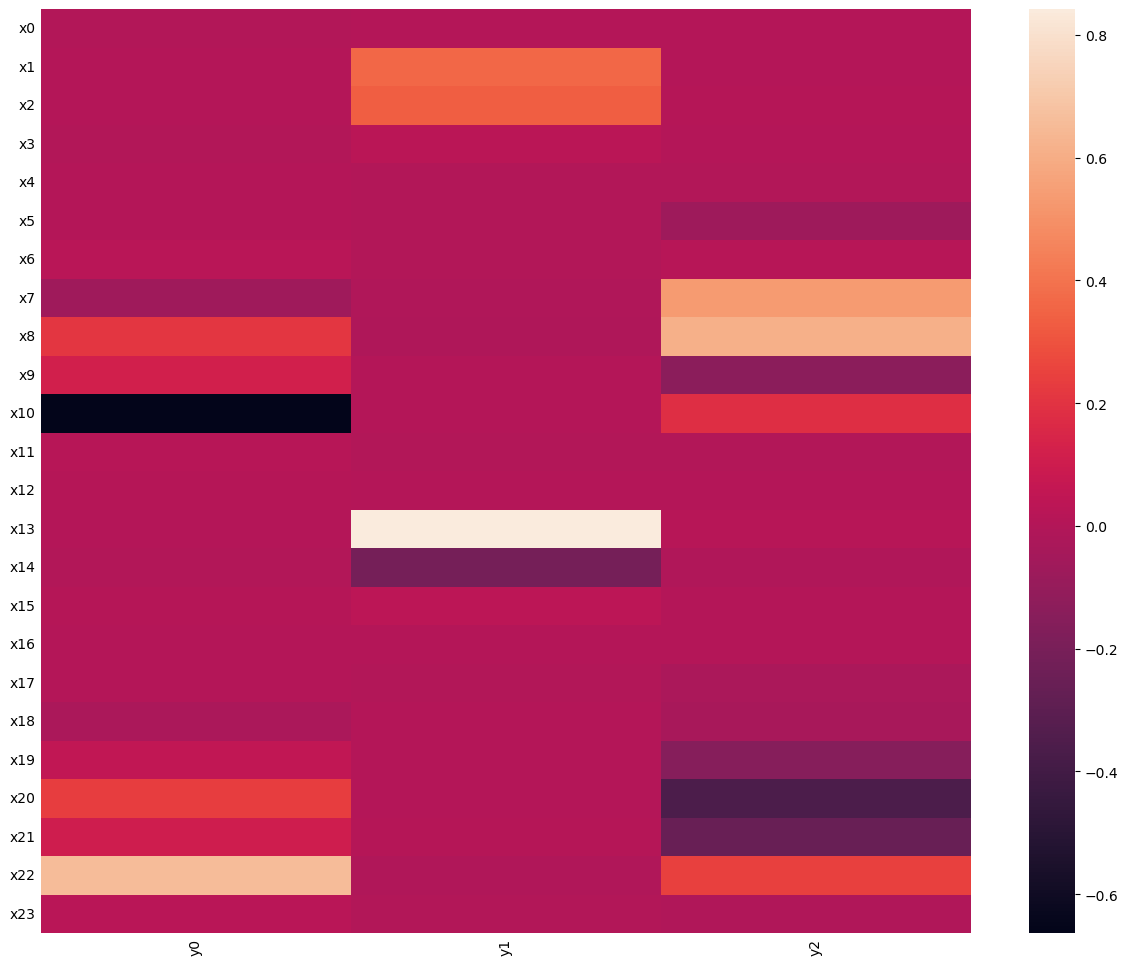

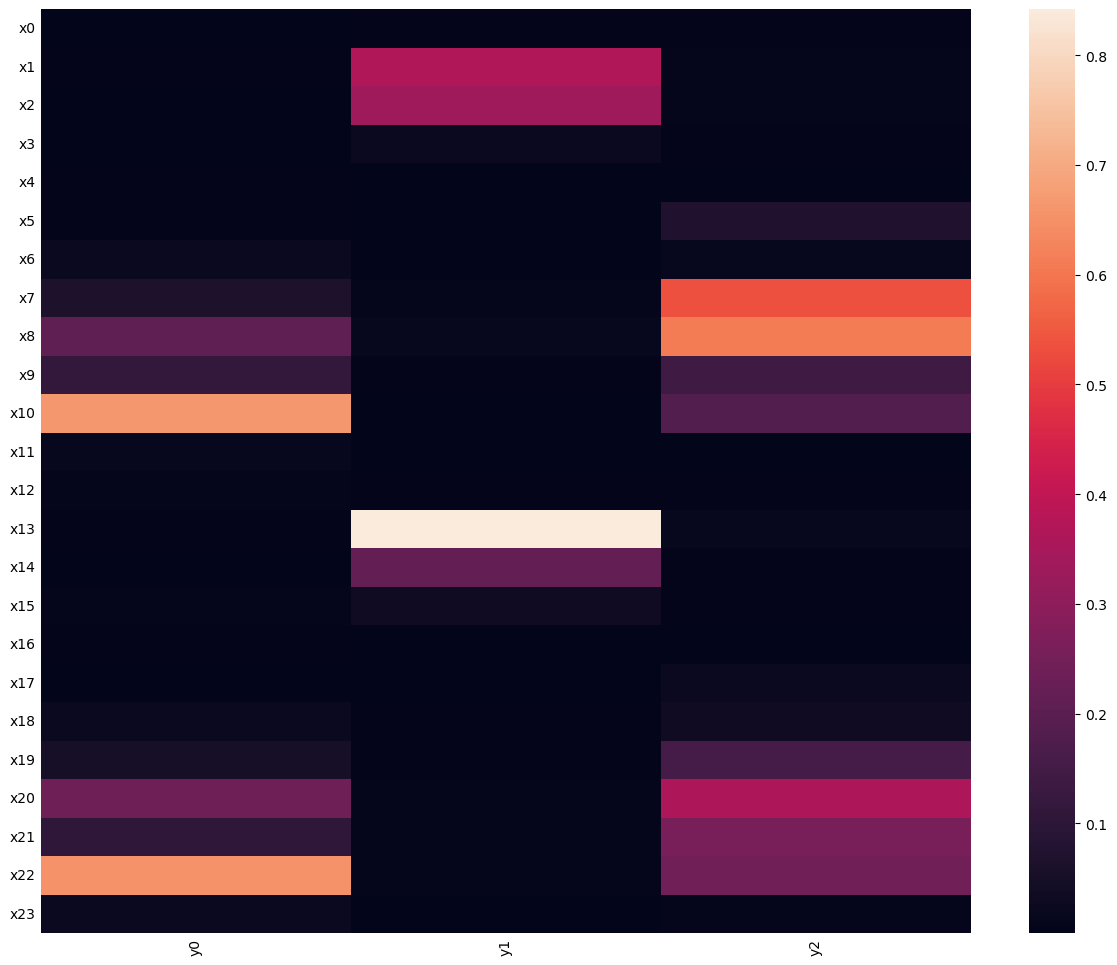

In [68]:
# 粗粒化函数系数
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [69]:
# 输出粗粒化函数表达式
print_equations(coarse_grain_coff, names, macro_name)

y0 = -0.0011 * x0 + 0.0035 * x1 + 0.0015 * x2 - 0.0001 * x3 + 0.0041 * x4 + 0.0038 * x5 + 0.0232 * x6 - 0.0648 * x7 + 0.2097 * x8 + 0.1146 * x9 - 0.6632 * x10 + 0.0160 * x11 + 0.0082 * x12 + 0.0046 * x13 - 0.0010 * x14 + 0.0093 * x15 + 0.0043 * x16 + 0.0030 * x17 - 0.0224 * x18 + 0.0510 * x19 + 0.2356 * x20 + 0.1025 * x21 + 0.6544 * x22 + 0.0217 * x23
------------------------------
y1 = 0.0040 * x0 + 0.3632 * x1 + 0.3316 * x2 + 0.0252 * x3 - 0.0011 * x4 + 0.0006 * x5 - 0.0018 * x6 - 0.0083 * x7 - 0.0135 * x8 + 0.0064 * x9 + 0.0026 * x10 - 0.0002 * x11 + 0.0058 * x12 + 0.8421 * x13 - 0.2155 * x14 + 0.0361 * x15 + 0.0025 * x16 + 0.0000 * x17 + 0.0053 * x18 + 0.0038 * x19 + 0.0067 * x20 + 0.0083 * x21 - 0.0083 * x22 - 0.0002 * x23
------------------------------
y2 = 0.0054 * x0 + 0.0067 * x1 + 0.0082 * x2 + 0.0059 * x3 + 0.0012 * x4 - 0.0696 * x5 + 0.0147 * x6 + 0.5356 * x7 + 0.6116 * x8 - 0.1398 * x9 + 0.1785 * x10 + 0.0000 * x11 + 0.0059 * x12 + 0.0163 * x13 - 0.0056 * x14 + 0.0044 * x1

# 描述宏观演化

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_89491/580934310.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


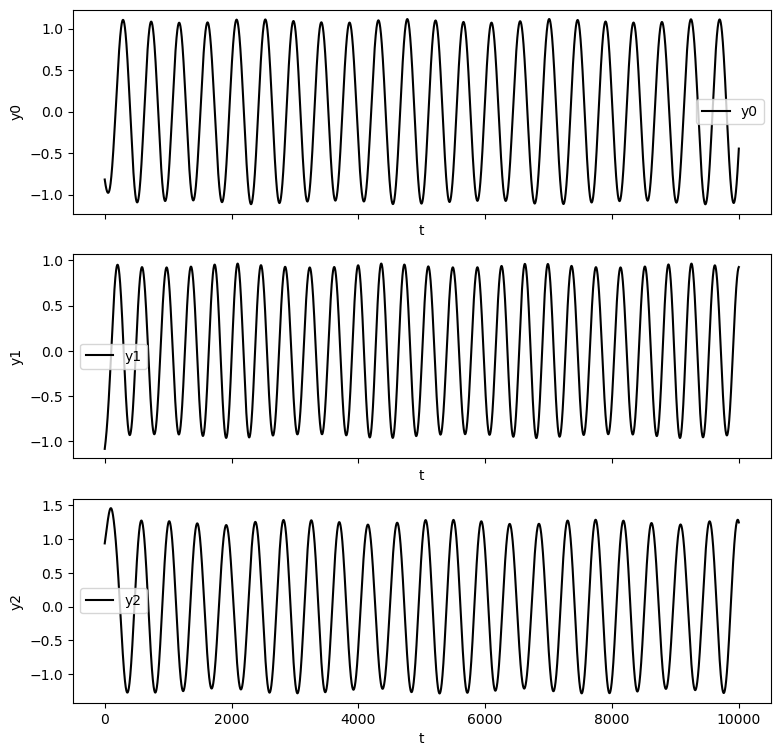

In [70]:
macro_data = x_data_lift @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

In [71]:
import numpy as np
from pysr import PySRRegressor

default_pysr_params = dict(
    populations=40,
    model_selection="best",
    niterations=40, # 迭代次数越多越精确，但越慢
    # 选择适合动力系统的算子
    binary_operators=["+", "-", "*", "/"],
    unary_operators=[
        "cos", "sin", "square", "cube"
        # "exp", "tanh" # 根据需要开启，Kuramoto 主要是三角函数
    ],
    maxsize=25, # 限制公式复杂度
    verbosity=0,
    procs=4, # 并行核心数
)


model_sr = PySRRegressor(**default_pysr_params)
model_sr.fit(macro_data[:-1,:], macro_data[1:,:])

eq = model_sr.sympy()
eq

/opt/anaconda3/envs/py311/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


[x0*1.0110435 + x2*0.01550949 - 1.35728005e-5/cos(x2)**3,
 -0.0019233321*x0 + x1,
 x0*(-0.020494461) + (x1*0.00065431267 + x2)*0.98869294]

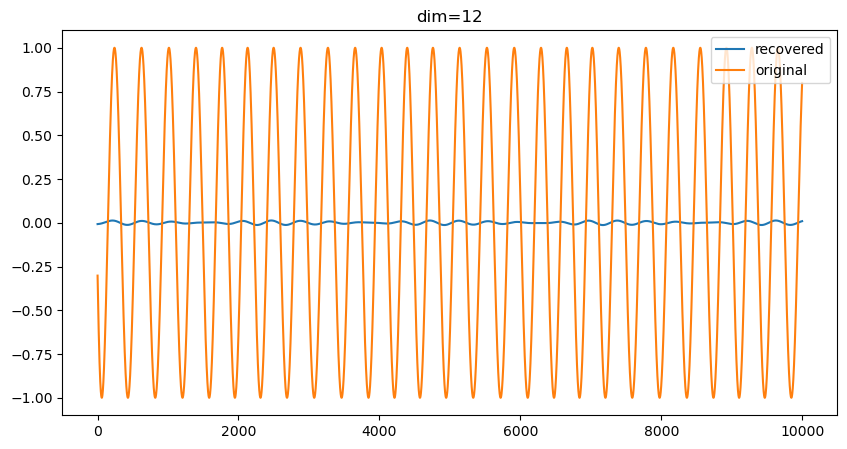

In [72]:
# 从宏观返到观测函数空间
recover_data = x_data_lift @ coarse_grain_coff @ coarse_grain_coff.T
ind = 12
recover_data_col = recover_data[:, ind]
x_data_col = x_data_lift[:, ind]

plt.figure(figsize=(10,5))
plt.plot(recover_data_col, label='recovered')
plt.plot(x_data_col, label='original')
plt.legend()
plt.title(f'dim={ind}')
plt.show()

(10000, 24)


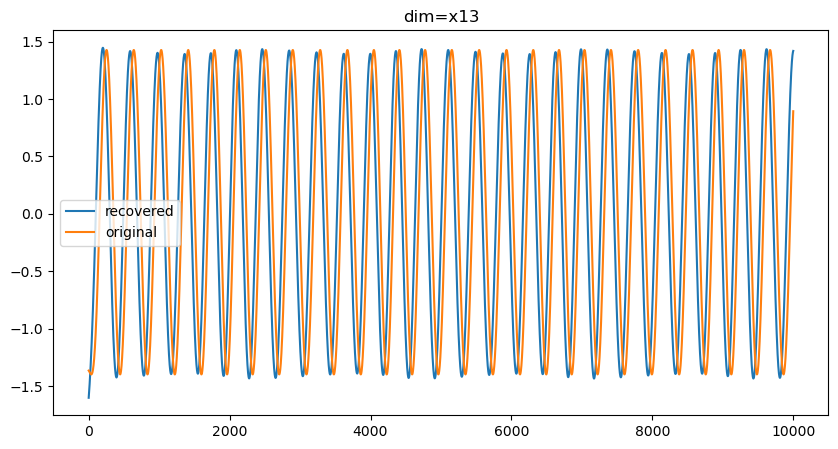

In [73]:
def filter_nonzero_columns(matrix, threshold=1e-10):
    """
    挑选出数组中所有非零列，并返回保留下来的列的原始索引。
    
    参数:
    matrix (np.ndarray or list): 输入的二维数组
    threshold (float): 判定为0的阈值
    
    返回:
    tuple: (filtered_matrix, original_indices)
           - filtered_matrix: 过滤后的 numpy 数组
           - original_indices: 一个包含保留列索引的 numpy 数组
    """
    arr = np.array(matrix)
    
    # 1. 创建布尔掩码 (Mask)
    # np.abs(arr) < threshold : 判断每个元素是否接近0
    # np.all(..., axis=0)     : 如果一列的所有元素都接近0，则该位置为 True
    # ~ (取反)                : 我们想要保留那些“不全是0”的列，所以取反
    keep_mask = ~np.all(np.abs(arr) < threshold, axis=0)
    
    # 2. 获取索引
    # np.where(keep_mask)[0] 会返回掩码中为 True 的位置索引
    indices = np.where(keep_mask)[0]
    
    # 3. 获取过滤后的矩阵
    # 利用布尔索引切片
    filtered_arr = arr[:, keep_mask]
    
    return filtered_arr, indices

def standard(data):
    data_stand = (data - np.mean(data) ) / np.std(data)
    return data_stand

recover_data_filt, indices = filter_nonzero_columns(recover_data, threshold=1e-10)
print(recover_data_filt.shape)
ind = 13
recover_data_col = recover_data_filt[:, ind]
x_data_col = x_data_lift[:, indices[ind]]
dff = standard(x_data_col) - standard(recover_data_col)

plt.figure(figsize=(10,5))
# plt.plot(recover_data_col, label='recovered')
# plt.plot(x_data_col, label='original')
plt.plot(standard(recover_data_col), label='recovered')
plt.plot(standard(x_data_col), label='original')
plt.legend()
plt.title(f'dim={names[indices[ind]]}')
plt.show()

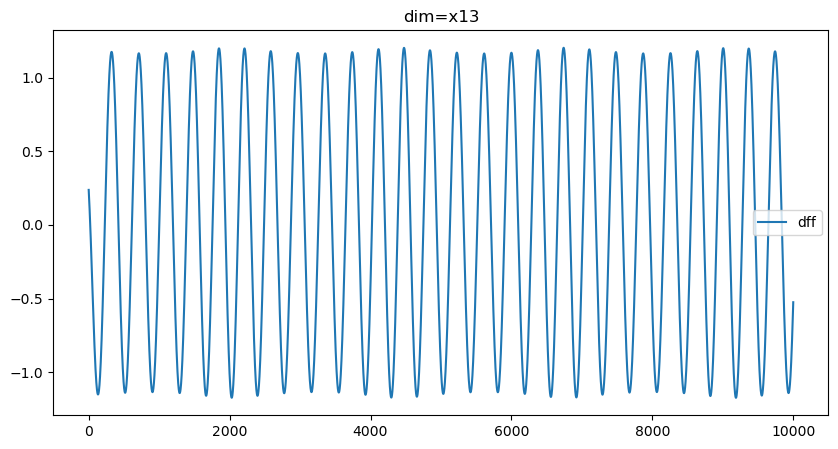

In [74]:
plt.figure(figsize=(10,5))
plt.plot(dff, label='dff')
plt.legend()
plt.title(f'dim={names[indices[ind]]}')
plt.show()

In [20]:
# 给出宏观动力学方程
A_macro = coarse_grain_coff.T @ A @ coarse_grain_coff
macro_name_k = [i+'[k]' for i in macro_name]
macro_name_next = [i+'[k+1]' for i in macro_name]
print_equations(A_macro, macro_name_k, macro_name_next)

y0[k+1] = 1.2644 * y0[k]
------------------------------
y1[k+1] = 0.2642 * y1[k] + 0.0036 * y2[k]
------------------------------
y2[k+1] = 0.0004 * y1[k] + 1.8922 * y2[k]
------------------------------


# 频谱分析

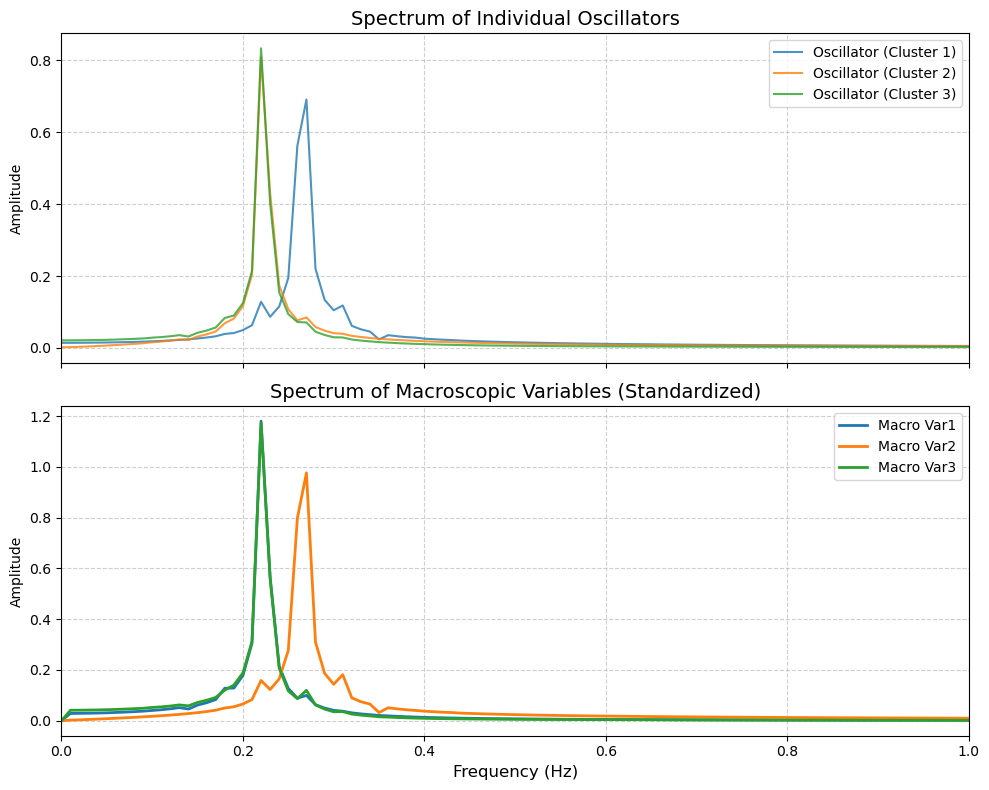

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

N=len(macro_data[:,0])
xf = np.fft.fftfreq(N, dt) 

micro_signals = [x_data[:, 0], x_data[:, 5], x_data[:, 10]]
micro_labels = ['Oscillator (Cluster 1)', 'Oscillator (Cluster 2)', 'Oscillator (Cluster 3)']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # 蓝、橙、绿

macro_signals = []
for i in range(macro_dim):
    sig = macro_data[:,i]
    standardized_sig = (sig - np.mean(sig) ) / np.std(sig)
    macro_signals.append(standardized_sig)
macro_labels = ['Macro Var1', 'Macro Var2', 'Macro Var3']

def compute_fft(signal, xf, N):
    yf = fft(signal)
    half_n = N // 2
    return xf[:half_n], np.abs(yf[:half_n]) / N * 2  # 归一化幅值


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- 第一幅图：原振子数据的频谱 ---
for i, sig in enumerate(micro_signals):
    freqs, amps = compute_fft(sig, xf, N)
    ax1.plot(freqs, amps, label=micro_labels[i], color=colors[i], alpha=0.8)

ax1.set_title("Spectrum of Individual Oscillators", fontsize=14)
ax1.set_ylabel("Amplitude")
ax1.legend(loc="upper right")
ax1.grid(True, linestyle='--', alpha=0.6)

# --- 第二幅图：宏观变量的频谱 (已标准化) ---
for i, sig in enumerate(macro_signals):
    freqs, amps = compute_fft(sig, xf, N)
    ax2.plot(freqs, amps, label=macro_labels[i], color=colors[i], linewidth=2)

ax2.set_title("Spectrum of Macroscopic Variables (Standardized)", fontsize=14)
ax2.set_xlabel("Frequency (Hz)", fontsize=12)
ax2.set_ylabel("Amplitude")
ax2.legend(loc="upper right")
ax2.grid(True, linestyle='--', alpha=0.6)

# 设置显示范围 (为了看清主峰，限制x轴范围)
ax2.set_xlim(0, 1) 

plt.tight_layout()
plt.show()
